In [16]:
pip install rasterio


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install numpy


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install scipy


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
# Corrected Code
# Correlation between IMD Rainfall and NDVI data

import os
import numpy as np
import rasterio
from glob import glob
from datetime import datetime, timedelta

# Define folders
imd_folder = r'/home/stormej/dev/varsha/data/rain/rain_resampled_monthly'
ndvi_folder = r'/home/stormej/dev/varsha/data/ndvi/ndvi_resampled_monthly'
output_folder = r'/home/stormej/dev/varsha/data/correlation/ndvi_imd'

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Initialize arrays to store sums
sum_imd, sum_ndvi, sum_imd_squared, sum_ndvi_squared, sum_product, count = (None,) * 6

# Get list of all files
imd_files = glob(os.path.join(imd_folder, 'imd_rain_sum_resampled_*.tif'))
ndvi_files = glob(os.path.join(ndvi_folder, 'modis_ndvi_avg_resampled_*.tif'))

# Sort the files to ensure they're processed in order
imd_files.sort()
ndvi_files.sort()

# Print file counts for debugging
print(f"Total IMD files found: {len(imd_files)}")
print(f"Total NDVI files found: {len(ndvi_files)}")

# Function to extract date from filename
def extract_date(filename, is_imd):
    """
    Extracts the date from the file name.
    Assumes IMD files are in the format 'imd_rain_sum_resampled_YYYY-MM.tif' and
    NDVI files are in the format 'modis_ndvi_avg_resampled_YYYY-MM.tif'.
    """
    return datetime.strptime(filename.split('_')[-1].split('.')[0], '%Y-%m')

# Process each pair of files
successfully_processed = 0
total_files = len(ndvi_files)

for index, ndvi_file in enumerate(ndvi_files, 1):
    ndvi_date = extract_date(os.path.basename(ndvi_file), is_imd=False)

    # Adjust IMD date to match the previous month for NDVI
    imd_date = ndvi_date - timedelta(days=30)  # Approximate one month backward
    imd_date_str = imd_date.strftime('%Y-%m')

    # Find matching IMD file
    matching_imd_file = next((f for f in imd_files if imd_date_str in f), None)

    if matching_imd_file:
        # Read NDVI data
        with rasterio.open(ndvi_file) as src:
            ndvi_data = src.read(1)
            if sum_ndvi is None:
                # Initialize arrays based on the shape of NDVI data
                sum_imd = np.zeros_like(ndvi_data, dtype=np.float64)
                sum_ndvi = np.zeros_like(ndvi_data, dtype=np.float64)
                sum_imd_squared = np.zeros_like(ndvi_data, dtype=np.float64)
                sum_ndvi_squared = np.zeros_like(ndvi_data, dtype=np.float64)
                sum_product = np.zeros_like(ndvi_data, dtype=np.float64)
                count = np.zeros_like(ndvi_data, dtype=np.int32)
                meta = src.meta

        # Read IMD data
        with rasterio.open(matching_imd_file) as src:
            imd_data = src.read(1)

        # Create a mask for valid data
        mask = ~np.isnan(imd_data) & ~np.isnan(ndvi_data)
        mask = mask & (imd_data >= 0) & (ndvi_data >= 0)

        if np.any(mask):
            # Update sums
            sum_imd[mask] += imd_data[mask]
            sum_ndvi[mask] += ndvi_data[mask]
            sum_imd_squared[mask] += imd_data[mask] ** 2
            sum_ndvi_squared[mask] += ndvi_data[mask] ** 2
            sum_product[mask] += imd_data[mask] * ndvi_data[mask]
            count[mask] += 1
            successfully_processed += 1

        else:
            print(f"Warning: No valid pixels found for NDVI: {ndvi_date.strftime('%Y-%m')} and IMD: {imd_date.strftime('%Y-%m')}")

    else:
        print(f"No matching IMD file for NDVI date: {ndvi_date.strftime('%Y-%m')}")

    # Print progress every 10 files
    if index % 10 == 0:
        print(f"Processed {index}/{total_files} files. Successfully matched: {successfully_processed}")

# Compute correlation and save output
if count is not None and np.sum(count) > 0:
    # Pearson correlation calculation
    n = count
    numerator = n * sum_product - sum_imd * sum_ndvi
    denominator = np.sqrt((n * sum_imd_squared - sum_imd ** 2) * (n * sum_ndvi_squared - sum_ndvi ** 2))
    valid_mask = (denominator > 0) & (n > 0)
    pearson_corr = np.full_like(sum_imd, np.nan)
    pearson_corr[valid_mask] = numerator[valid_mask] / denominator[valid_mask]

    # Save as GeoTIFF
    output_file = os.path.join(output_folder, 'pearson_correlation_monthly_imd_ndvi.tif')
    meta.update(dtype='float32', nodata=np.nan)

    with rasterio.open(output_file, 'w', **meta) as dst:
        dst.write(pearson_corr.astype('float32'), 1)

    print(f"Correlation saved to {output_file}")
else:
    print("No valid data to calculate correlation.")


Total IMD files found: 276
Total NDVI files found: 275
Processed 10/275 files. Successfully matched: 8
Processed 20/275 files. Successfully matched: 18
Processed 30/275 files. Successfully matched: 27
Processed 40/275 files. Successfully matched: 34
Processed 50/275 files. Successfully matched: 43
Processed 60/275 files. Successfully matched: 52
Processed 70/275 files. Successfully matched: 62
Processed 80/275 files. Successfully matched: 70
Processed 90/275 files. Successfully matched: 76
Processed 100/275 files. Successfully matched: 85
Processed 110/275 files. Successfully matched: 93
Processed 120/275 files. Successfully matched: 103
Processed 130/275 files. Successfully matched: 113
Processed 140/275 files. Successfully matched: 121
Processed 150/275 files. Successfully matched: 129
Processed 160/275 files. Successfully matched: 137
Processed 170/275 files. Successfully matched: 145
Processed 180/275 files. Successfully matched: 155
Processed 190/275 files. Successfully matched: 1

In [9]:
pip install cartopy


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


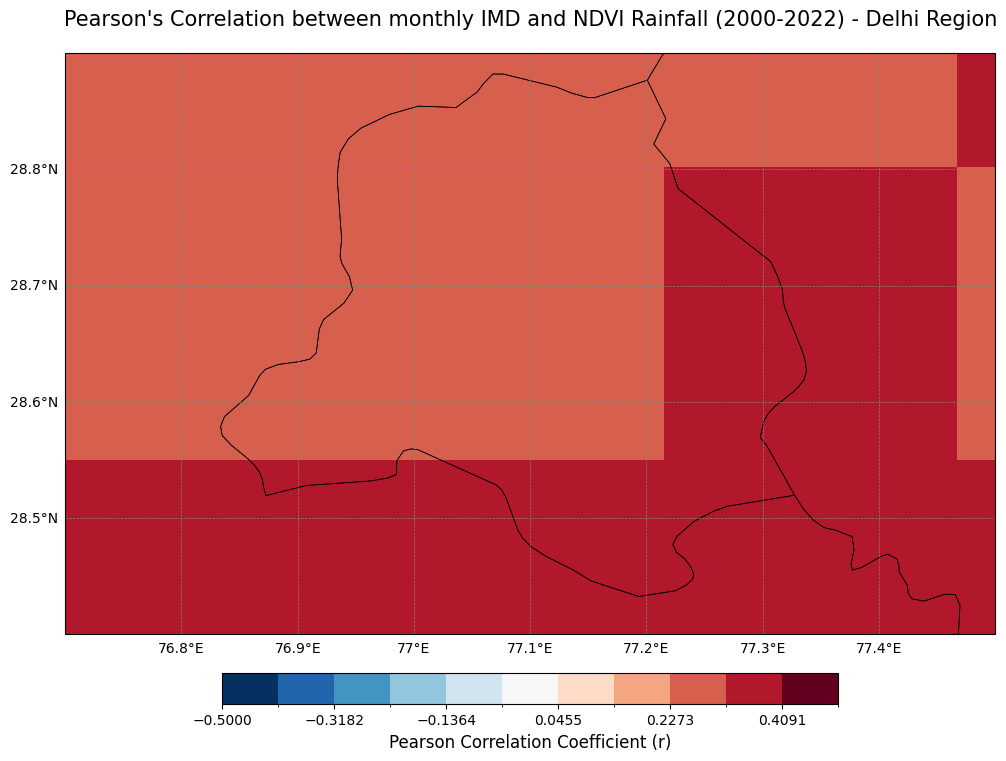

In [10]:
from matplotlib.colors import ListedColormap, BoundaryNorm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_correlation_map_delhi(file_path):
    # Load the GeoTIFF file
    with rasterio.open(file_path) as src:
        correlation_data = src.read(1)
        # Get the transformation parameters
        transform = src.transform
        height = src.height
        width = src.width
        
        # Calculate coordinates properly using the transform
        lon = np.linspace(transform[2], transform[2] + width * transform[0], width)
        lat = np.linspace(transform[5] + height * transform[4], transform[5], height)
        
        # Create meshgrid for proper plotting
        lon_mesh, lat_mesh = np.meshgrid(lon, lat)

    # Create color map
    colors = ['#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#f7f7f7', 
              '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#62001f']
   
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(np.linspace(-0.5, 0.5, len(colors) + 1), cmap.N)

    # Create figure with adjusted extent
    fig, ax = plt.subplots(figsize=(12, 10), 
                           subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Set extent to cover the Delhi region (adjusted bounds)
    ax.set_extent([76.7, 77.5, 28.4, 28.9], crs=ccrs.PlateCarree())

    # Plot the correlation data using pcolormesh with explicit coordinates
    correlation_plot = ax.pcolormesh(
        lon_mesh, lat_mesh, correlation_data,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=norm,
        shading='auto'  # Add shading parameter
    )

    # Add features with zorder to control layering
    ax.add_feature(cfeature.BORDERS, linewidth=1.2, edgecolor='black', zorder=3)
    ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black', zorder=3)
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='black', zorder=2)

    # Add and format gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', 
                     linestyle='--', zorder=1)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    # Add colorbar
    cbar = plt.colorbar(correlation_plot, ax=ax, orientation='horizontal', 
                       pad=0.05, fraction=0.04)
    cbar.set_label('Pearson Correlation Coefficient (r)', fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    # Set title
    plt.title("Pearson's Correlation between monthly IMD and NDVI Rainfall (2000-2022) - Delhi Region", 
             fontsize=15, pad=20)

    return fig, ax

# Define the file path for the correlation data
file_path = os.path.join(output_folder, 'pearson_correlation_monthly_imd_ndvi.tif')

# Usage
fig, ax = plot_correlation_map_delhi(file_path)
plt.show()


# Correlation between IMD Rainfall and NDVI in Delhi Region between years 2000 and 2022

**Moderate correlation**

In this procedure, we lead the ndvi values the imd values by one month. As we get a moderate correlation, it means that this is a more true to life correlation as Delhi Region in general has lower vegetation cover. This also means that ndvi might not be the best auxillary variable for our purpose.